In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


calories = pd.read_csv('../Dataset/calories.csv')
exercise = pd.read_csv('../Dataset/exercise.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df = df.drop(columns=['User_ID'])
#Mapper male til 1 og kvinder til 0 for at spare data
df['Gender'] = df['Gender'].map({'male': 1, 'female': 0})
df = df.reset_index()

#Vi laver feature transformation til vores data nu, og standardizerer det
scaler = StandardScaler()
df[['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']] = scaler.fit_transform(df[['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']])

X = df.drop(columns=['Calories','index'])
X
y = df['Calories']

df.head()


,index,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,1,68,1.089582,1.265909,1.619127,0.989404,0.994023,231.0
1,1,0,20,-0.593726,-0.995458,-0.183990,-0.158461,0.352342,66.0
2,2,1,69,0.318066,0.268247,-1.265861,-0.784569,-1.701035,26.0
3,3,0,34,0.318066,-0.263839,-0.304198,0.467647,0.609015,71.0
4,4,0,27,-1.435380,-1.128480,-0.664821,-1.515029,-0.289338,35.0


Best lambda: 0.2395, CV error: 127.1224


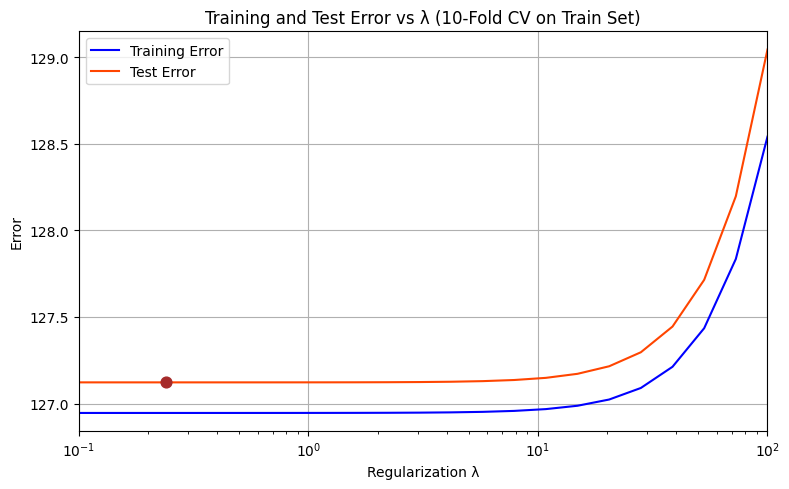

In [3]:
# Define the lambda range that mirrors the original plot
lambdas = np.logspace(-2, 2, 30)

# Split the dataset into train and test for error evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For each lambda, perform 10-fold CV on training set to estimate test error,
# and calculate training error on the full training set
cv = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors = []
cv_errors = []

for l in lambdas:
    model = make_pipeline(StandardScaler(), Ridge(alpha=l))
    # Train error on training set
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_errors.append(train_mse)
    
    # Cross-validation error (proxy for test/generalization error)
    cv_mse = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    cv_errors.append(cv_mse)

min_index = np.argmin(cv_errors)
best_lambda = lambdas[min_index]
best_error = cv_errors[min_index]

print(f"Best lambda: {best_lambda:.4f}, CV error: {best_error:.4f}")

# Plot to match the style of the example
plt.figure(figsize=(8, 5))
plt.plot(lambdas, train_errors, label="Training Error", color='blue')
plt.plot(lambdas, cv_errors, label="Test Error", color='orangered')
plt.scatter([lambdas[min_index]], cv_errors[min_index],
            color='brown', s=60, zorder=5)
plt.xlim(1e-1, 1e2)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel("Regularization λ")
plt.ylabel("Error")
plt.title("Training and Test Error vs λ (10-Fold CV on Train Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# Re-prepare data from the original DataFrame
feature_names = X.columns.tolist()

# Refit the pipeline with the correct data structure
best_model = make_pipeline(StandardScaler(), Ridge(alpha=best_lambda))
best_model.fit(X_train, y_train)

# Extract steps
scaler_step = best_model.named_steps['standardscaler']
ridge_step = best_model.named_steps['ridge']
coefs = ridge_step.coef_
intercept = ridge_step.intercept_

# Output weight interpretation
weights_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight (w_i)': coefs
})

weights_df


,Feature,Weight (w_i)
0,Gender,-0.686696
1,Age,8.499936
2,Height,-2.411853
3,Weight,4.294196
4,Duration,55.018009
5,Heart_Rate,18.994994
6,Body_Temp,-13.172675


Færdig med Regression part a)

In [5]:
#Baseline model

# Use y from your dataset (already defined earlier)
K1 = 10  # outer folds
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=42)

baseline_mse_scores = []

for train_idx, test_idx in outer_cv.split(X):
    # Split into training and test for this outer fold
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Baseline model: mean of y_train
    y_pred_baseline = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
    
    # Compute and store MSE for this outer fold
    mse = mean_squared_error(y_test, y_pred_baseline)
    baseline_mse_scores.append(mse)

# Final estimated generalization error (average over outer folds)
baseline_avg_mse = np.mean(baseline_mse_scores)
print(f"Baseline Model - Estimated Generalization Error (MSE): {baseline_avg_mse:.4f}")


Baseline Model - Estimated Generalization Error (MSE): 3901.9368


In [6]:
from sklearn.neural_network import MLPRegressor

# Range of hidden unit sizes to try, including h=1
hidden_units_range = [1, 2, 5, 10, 20]

# Outer 10-fold CV
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

# To store MSE for each outer fold with its corresponding best h
ann_results = []

for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    best_h = None
    best_mse = float('inf')

    # Inner CV to tune hidden units
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    for h in hidden_units_range:
        inner_mse_scores = []

        for inner_train_idx, inner_val_idx in inner_cv.split(X_train):
            X_inner_train = X_train.iloc[inner_train_idx]
            y_inner_train = y_train.iloc[inner_train_idx]
            X_inner_val = X_train.iloc[inner_val_idx]
            y_inner_val = y_train.iloc[inner_val_idx]

            # Fit ANN with h hidden units
            ann = MLPRegressor(hidden_layer_sizes=(h,), max_iter=1000, early_stopping=True, random_state=42)
            ann.fit(X_inner_train, y_inner_train)

            y_val_pred = ann.predict(X_inner_val)
            mse = mean_squared_error(y_inner_val, y_val_pred)
            inner_mse_scores.append(mse)

        avg_inner_mse = np.mean(inner_mse_scores)

        # Track best h
        if avg_inner_mse < best_mse:
            best_mse = avg_inner_mse
            best_h = h

    # Refit on entire training data with best h
    final_ann = MLPRegressor(hidden_layer_sizes=(h,), max_iter=1000, early_stopping=True, random_state=42)
    final_ann.fit(X_train, y_train)
    y_test_pred = final_ann.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)

    ann_results.append((best_h, test_mse))

# Convert results to a readable DataFrame
ann_results_df = pd.DataFrame(ann_results, columns=["Best_h", "Test_MSE"])
